In [2]:
!pip install photutils --quiet

In [3]:
import numpy as np
import astropy
import sep
import photutils as phot
from matplotlib import pyplot as plt
from astroquery.skyview import SkyView
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import astropy.units as u
from astropy.wcs import WCS
import astropy.stats as stats

# To improve Aesthetics of plots

import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)
matplotlib.rcParams['font.size'] = 15

from astropy.visualization import astropy_mpl_style

plt.style.use(astropy_mpl_style)

# **Source Extraction Using Image Segmentation**

Photutils includes a general-use function to detect sources (both point-like and extended) in an image using a process called image segmentation in the computer vision field. After detecting sources using image segmentation, we can then measure their photometry, centroids, and morphological properties by using additional tools in Photutils.

Using Skyview to obtaining 'SDSSi' image of 'Abell 400' with radius 10 arcminutes and 512 pixels

In [4]:
position = 'Abell 400'
radius = 10

path = SkyView.get_images(
    position = position,
    radius = radius*u.arcmin,
    pixels = 512,
    survey = ['SDSSi']
)

In [5]:
data = path[0][0].data

In [6]:
# Direct function for Log Stretch
norm = ImageNormalize(stretch = LogStretch())

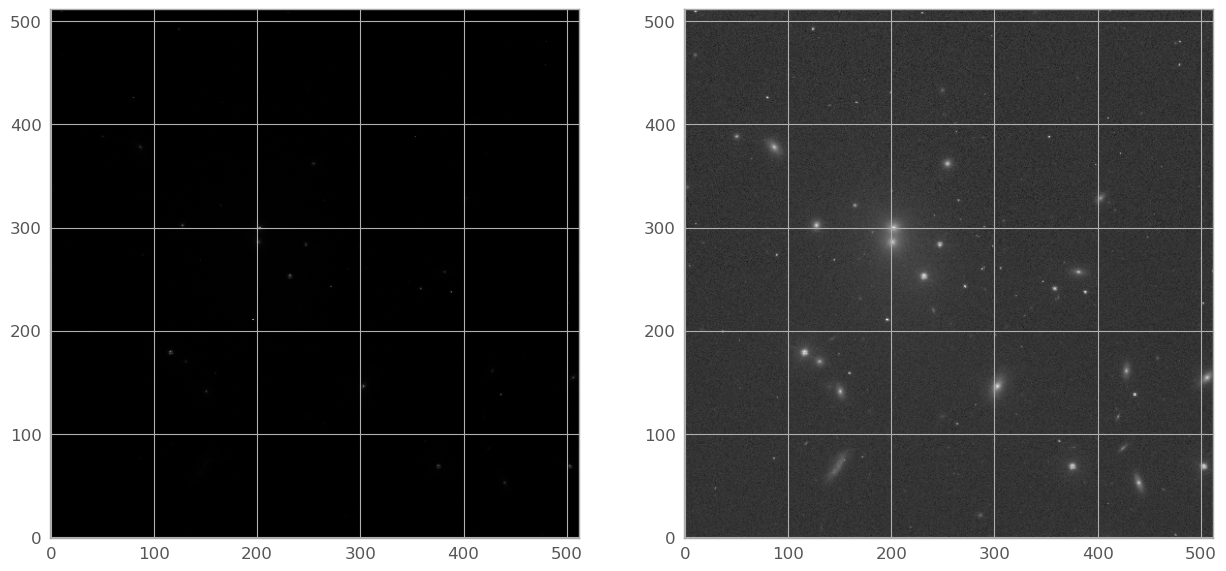

In [7]:
#code to display orginal image and normalized_image side by side
fig = plt.figure(figsize = (15, 20))
ax = fig.subplots(1, 2)

ax[0].imshow(
    data,
    origin = 'lower',
    cmap = 'gray',
)
ax[1].imshow(
    data,
    origin = 'lower',
    cmap = 'gray',
    norm = norm
)

In the image above in right side we see a number of galaxies. Our objective is to find coordinates of all bright sources. This is a standard problem in Astronomy and is called as Source extraction. There are number of methods for source detection, we will be using the method of Segmentation.

To able to associate coordinates with the sources in the image, first we need to know the coordinates (RA and Dec) associated to each point in the image. This is where where we use the [WCS](http://tdc-www.harvard.edu/wcstools/wcstools.wcs.html) feature of a FITS image. 

In [8]:
wcs = WCS(path[0][0].header)
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 44.4058  6.0125  
CRPIX : 256.5  256.5  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0003255208333333333  0.0003255208333333333  
NAXIS : 512  512

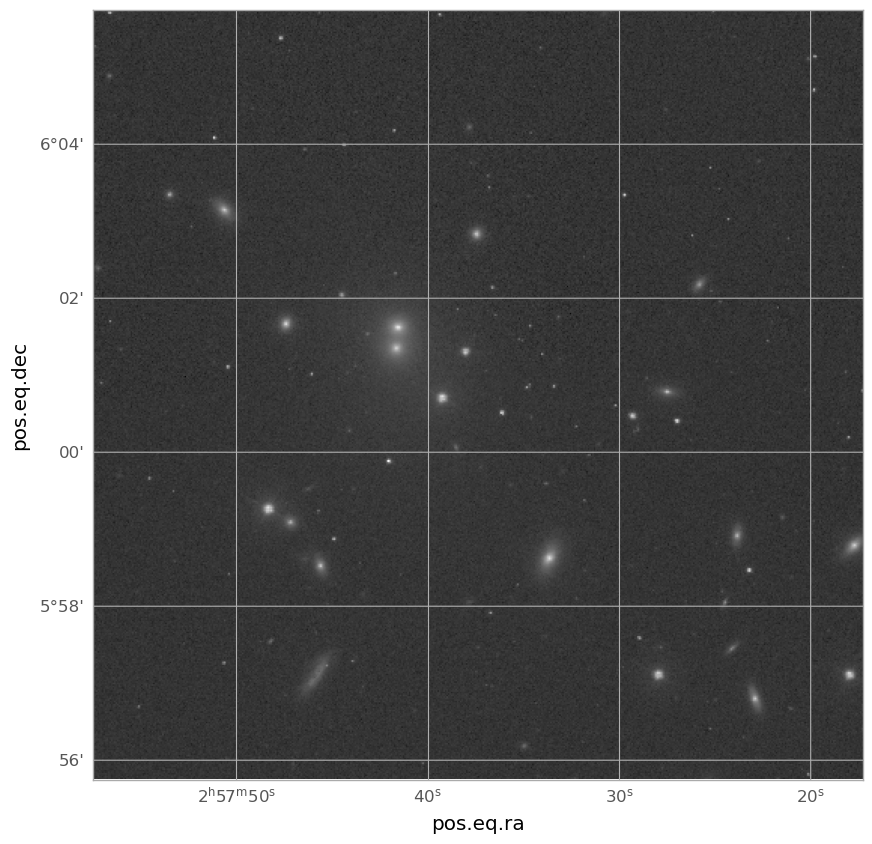

In [9]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(projection = wcs)
norm = ImageNormalize(data, stretch = LogStretch())
ax.imshow(
    data,
    cmap = 'gray',
    norm = norm
)

## **3 Sigma**

In the empirical sciences the so-called three-sigma rule of thumb expresses a conventional heuristic that nearly all values are taken to lie within three standard deviations of the mean, and thus it is empirically useful to treat 99.7% probability as near certainty

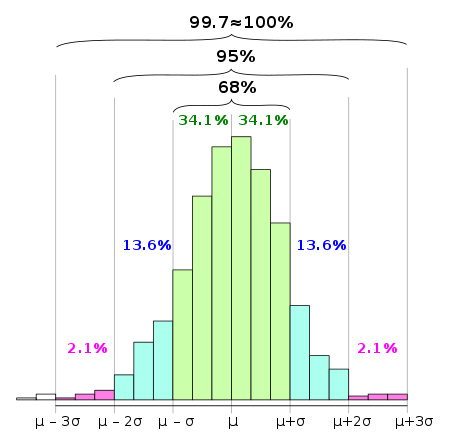

In our context we'll be assigning coordinates to all sources which have flux greater than 3 sigma

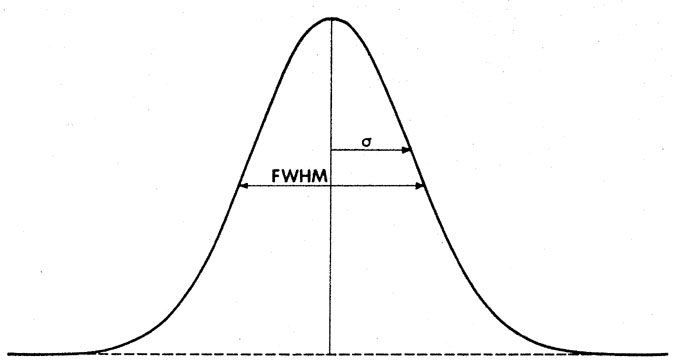

We will look for sources which lie between 3 FWHM

Now

FWHM = $2\sqrt{2\ln2}\sigma$

This implies

sigma $\approx$ 1/2.354 FWHM

stats.gaussian_fwhm_to_sigma gives the value of 1/$2\sqrt{2\ln2}$ to a higher precision

## **Detection**

In [10]:
sigma = 3.0*stats.gaussian_fwhm_to_sigma #FWHM = 3
sigma

1.2739827004320285

Next we create a filter for convolution. You can learn more about convolution [here](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)

In [11]:
kernel = astropy.convolution.Gaussian2DKernel(sigma, x_size = 3, y_size = 3)
kernel.normalize()

code to estimate background of Abell 400 with bh=bw=8 and fh=fw=3.

In [12]:
data = data.byteswap().newbyteorder()

In [13]:
background = sep.Background(data, bh = 8, bw = 8, fh = 3, fw = 3)
#let's use a threshold of 5*RMS above the background.
threshold = background.back() + (5 * background.rms())

Displaying 2D data in the variable threshold to visualize the background

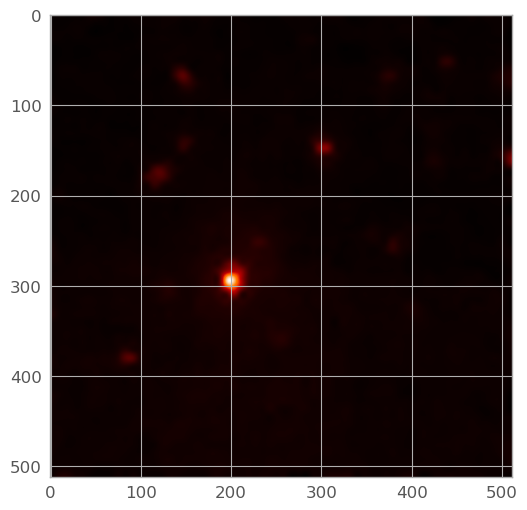

In [14]:
plt.imshow(threshold)

In [15]:
segm = phot.detect_sources(
    data,
    threshold,
    npixels = 5,
    kernel = kernel
)
cmap_segm = segm.make_cmap(seed = 123)

/tmp/ipykernel_5001/4045498693.py:1: DeprecationWarning: `photutils.detect_sources` is a deprecated alias for `photutils.segmentation.detect_sources` and will be removed in the future. Instead, please use `from photutils.segmentation import detect_sources` to silence this warning.
  segm = phot.detect_sources(


In [16]:
from photutils.utils import interpolation

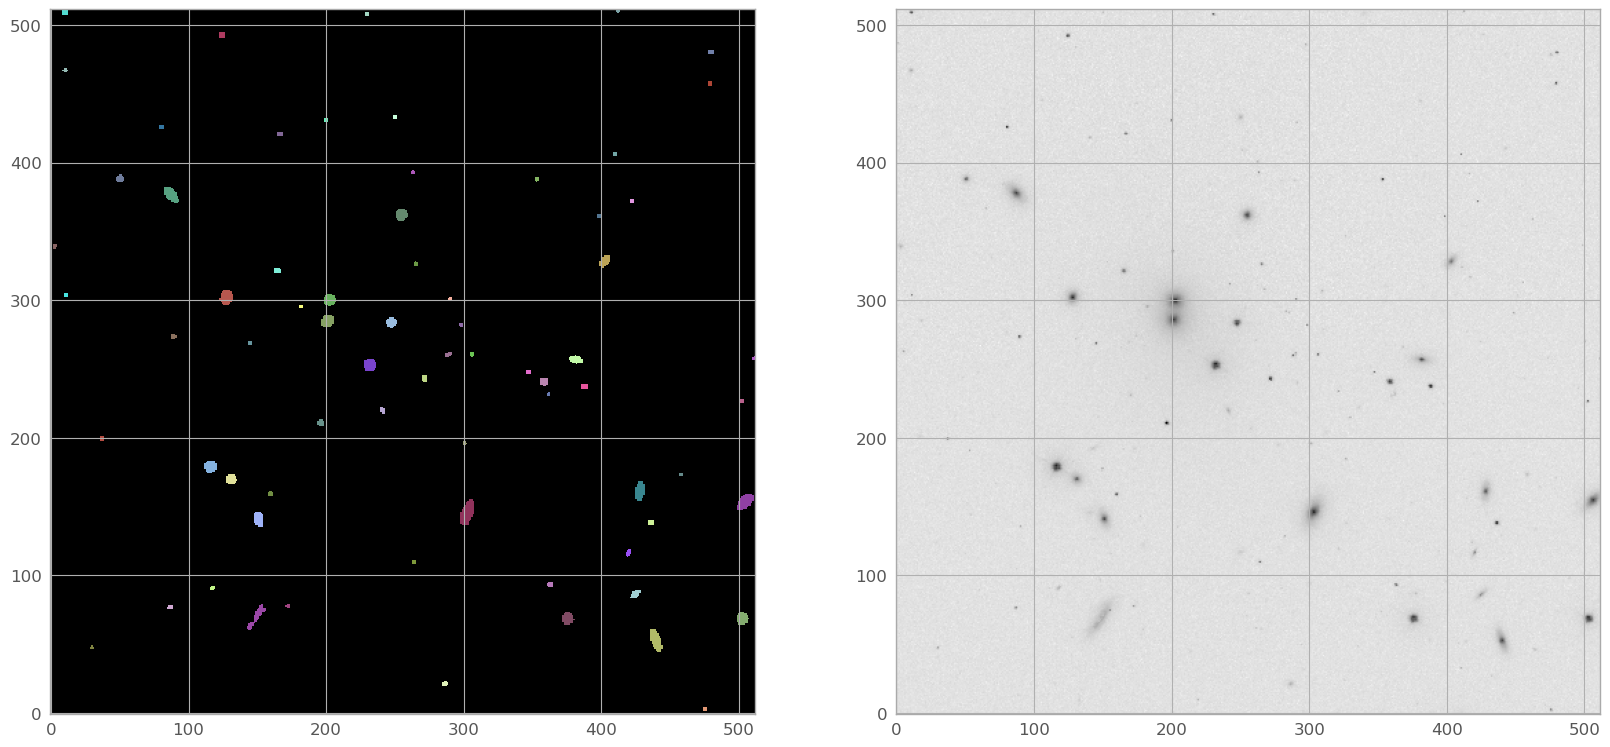

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
ax[0].imshow(
    segm,
    cmap = cmap_segm,
    interpolation = 'nearest',
    origin = 'lower'
)
ax[1].imshow(
    data,
    cmap = 'Greys',
    norm = norm,
    origin = 'lower'
)

In [18]:
sources = phot.SourceCatalog(
    data,
    segm,
    wcs = wcs
)
catalog = sources.to_table()

# optional format
catalog['xcentroid'].info.format = '.2f'  
catalog['ycentroid'].info.format = '.2f'
catalog['kron_flux'].info.format = '.2f'

/tmp/ipykernel_5001/969116899.py:1: DeprecationWarning: `photutils.SourceCatalog` is a deprecated alias for `photutils.segmentation.SourceCatalog` and will be removed in the future. Instead, please use `from photutils.segmentation import SourceCatalog` to silence this warning.
  sources = phot.SourceCatalog(


Thus we have a catalog of all sources in the image

In [19]:
catalog

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,"deg,deg",,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,SkyCoord,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,475.19,2.68,"44.333900180976336,5.930197101639332",474,476,2,4,9.0,0.5650951218742462,0.4618035201012971,-56.31061737296465,0.5763346590645594,0.026641845703125,2.71875,0.0,5.615692138671875,nan,5.71,nan
2,286.34,21.47,"44.395705211890906,5.936318741288683",285,288,20,23,13.0,0.931769183049509,0.7755884425490048,37.707583203941034,0.5542014343147394,0.208740234375,1.009765625,0.0,6.15380859375,nan,10.36,nan
3,439.72,52.91,"44.345506935109945,5.946550372898321",436,444,45,61,101.0,2.998250253189812,1.2626985049583395,-71.25895311439551,0.9069932612870619,0.310546875,18.15625,0.0,143.421875,nan,161.75,nan
4,29.94,47.64,"44.479622056065665,5.944831412646446",29,31,47,49,7.0,0.5254586830072443,0.4308526143339182,56.57934521800953,0.5724276035729143,0.026641845703125,1.60546875,0.0,3.054473876953125,nan,3.19,nan
5,149.49,70.10,"44.440495305937965,5.952148580084708",143,156,61,79,78.0,5.73531637232585,1.1875824071615018,56.12439207552977,0.9783272198680533,0.2724609375,2.79296875,0.0,62.81396484375,nan,164.62,nan
6,375.55,69.01,"44.366509104251854,5.951791060551334",372,380,65,73,63.0,1.4460633433888586,1.3941517720054284,87.57502240419075,0.2655341528019367,0.25390625,22.46875,0.0,197.5791015625,nan,205.94,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,10.51,467.01,"44.486000583603015,6.081346265714044",9,12,466,468,8.0,0.6952343355084192,0.6108136779266383,2.8412714595000796,0.4776092445571863,0.23583984375,1.337890625,0.0,4.53564453125,nan,6.66,nan


Let's plot [Kron Apertures](https://wise2.ipac.caltech.edu/staff/jarrett/2mass/3chan/kron/kron.html) around sources

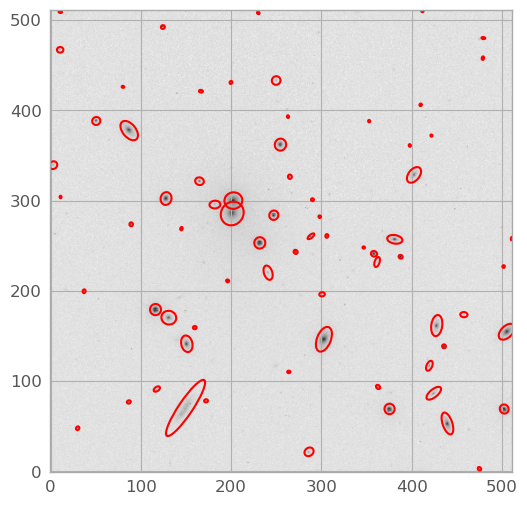

In [20]:
fig, ax = plt.subplots(1)
ax.imshow(
    data,
    origin = 'lower',
    cmap = 'Greys',
    norm = norm
)

for aperture in sources.kron_aperture:
    if aperture is not None:
        aperture.plot(
            axes = ax,
            color = 'red',
            lw = 1.5
        )

## **Querying Catalog**

Now that we have tabular data, we can pass queries for understanding the distribuition.
Searching for label with longest semimajor axis ( based of segmentation map)

In [21]:
label = catalog[catalog['semimajor_sigma'] == catalog['semimajor_sigma'].max()]['label']

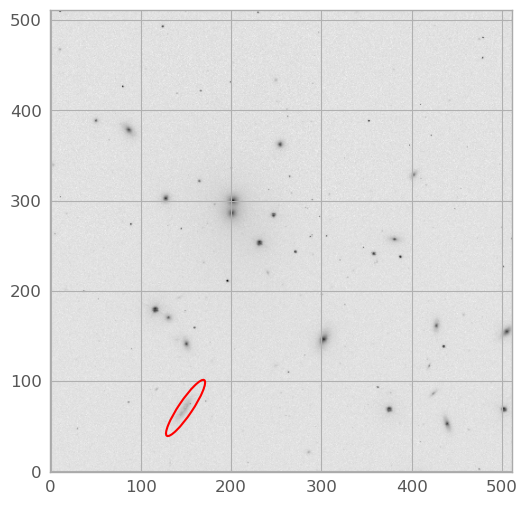

In [22]:
# Getting the source using label
q = sources.get_label(label)

# Plotting the queried source and marking it using aperture
fig, ax = plt.subplots(1)
ax.imshow(
    data,
    cmap = 'Greys',
    norm = norm,
    origin = 'lower'
)

for aperture in q.kron_aperture:
    if aperture is not None:
        aperture.plot(
            axes = ax,
            color = 'red',
            lw = 1.5
        )

In [23]:
q.to_table()#Converting to QTable

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,"deg,deg",,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,SkyCoord,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
5,149.49055914429857,70.10369783042995,"44.440495305937965,5.952148580084708",143,156,61,79,78.0,5.73531637232585,1.1875824071615018,56.12439207552977,0.9783272198680533,0.2724609375,2.79296875,0.0,62.81396484375,nan,164.62050317764158,nan


In [24]:
q.to_table()['sky_centroid']#Position of the source that can be passed on to skyview

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(44.44049531, 5.95214858)]>

# **Data Modelling**

Preliminary analysis in astronomical image processing
includes understanding the dimensional properties or the shape
index profile of the celestial object in the image. For quantifying the dimensions astronomers often choose a profile and fit it to the data. 

Astropy has provision for multidimensional curve fitting and has quite many profiles for modeling the data. [Learn more](https://docs.astropy.org/en/stable/modeling/predef_models2D.html)

In [39]:
from astropy.modeling import models, fitting

Use Skyview to obtain 'SDSSz' image of M 89' with radius 3 arcminutes and 512 pixels

In [25]:
position = 'M 89'
radius = 3
path = SkyView.get_images(
    position = position,
    radius = radius*u.arcmin,
    pixels = 512,
    survey = ['SDSSz']
)

In [26]:
data = path[0][0].data

Text(0.5, 1.0, 'Position : M 89')

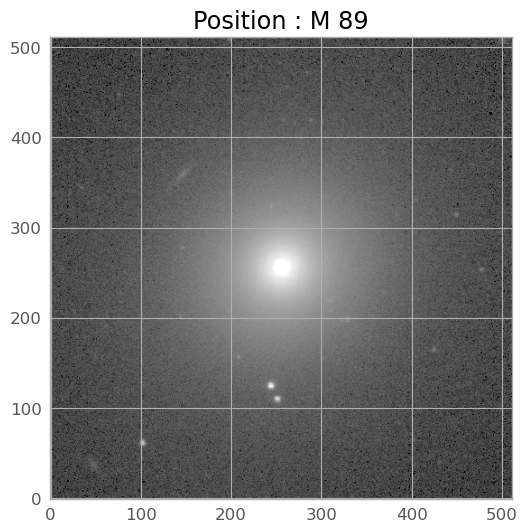

In [28]:
plt.imshow(
    data,
    origin = 'lower',
    cmap = 'gray',
    norm = norm
)
plt.title("Position : M 89")

In [42]:
# Initialize Guassian2D model
init = models.Gaussian2D()

In [43]:
# Choosing the fitting method
fit = fitting.LevMarLSQFitter()

# Creating a x,y mesh for giving every point in the image an x,y coordinate and normalizing it to [-1,1]
x, y = np.mgrid[-256:256, -256:256]/256

In [44]:
#fit the modelto data
model = fit(init, x, y, z = data)
model

<Gaussian2D(amplitude=134.7749989, x_mean=-0.00007947, y_mean=0.00355122, x_stddev=0.03760611, y_stddev=0.03945913, theta=12.07299341)>

In [46]:
model(x, y)#model array

array([[8.29771212e-281, 9.75178853e-280, 1.13463902e-278, ...,
        7.92854567e-299, 5.67427749e-300, 4.02045436e-301],
       [1.11023246e-279, 1.30532632e-278, 1.51939886e-277, ...,
        1.30886353e-297, 9.37110209e-299, 6.64254489e-300],
       [1.46987373e-278, 1.72887848e-277, 2.01324409e-276, ...,
        2.13799042e-296, 1.53137418e-297, 1.08593646e-298],
       ...,
       [8.58485418e-301, 1.24481299e-299, 1.78699292e-298, ...,
        2.27937228e-272, 2.01269320e-273, 1.75949252e-274],
       [5.29859241e-302, 7.68618737e-301, 1.10384717e-299, ...,
        1.73575383e-273, 1.53330910e-274, 1.34096926e-275],
       [3.23592657e-303, 4.69600311e-302, 6.74692094e-301, ...,
        1.30789101e-274, 1.15582584e-275, 1.01125521e-276]])

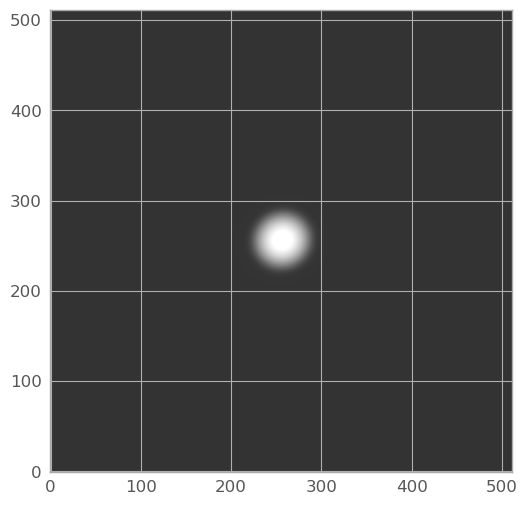

In [53]:
plt.imshow(
    model(x, y),
    origin = 'lower',
    cmap = 'gray',
    norm = norm
)

In [56]:
# Subtract model from data and plot it
residual = np.subtract(data, model(x, y))

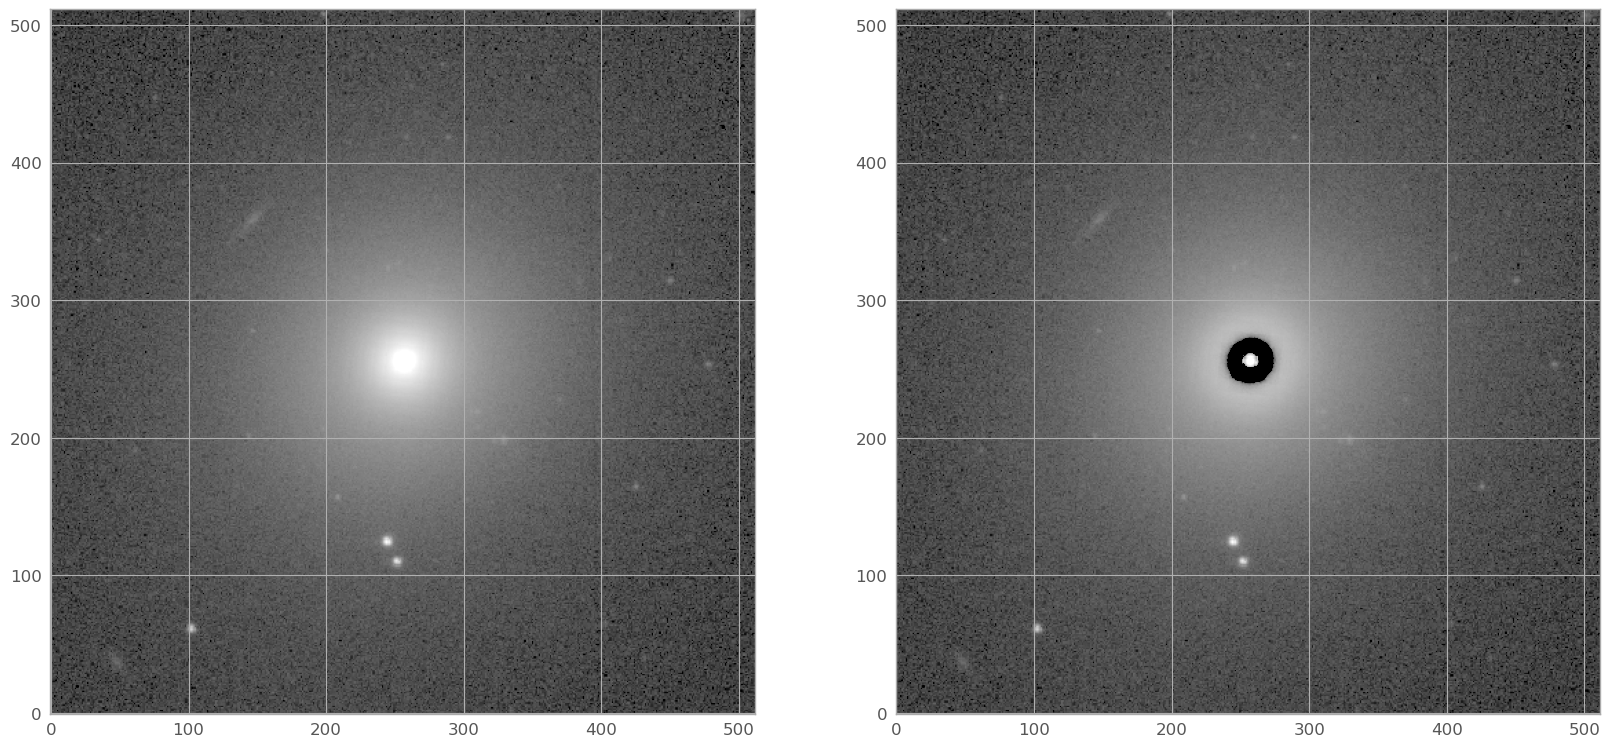

In [59]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
ax[0].imshow(
    data,
    cmap = 'gray',
    origin = 'lower',
    norm = norm
)
ax[1].imshow(
    residual,
    cmap = 'gray',
    origin = 'lower',
    norm = norm
)